In [ ]:
# This cell mounts Google Drive to the Colab environment.
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully!")

Mounted at /content/drive
Google Drive mounted successfully!


MUST RUN COMMANDS

In [ ]:
!pip install bm3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 14.7 MB/s eta 0:00:00


IMAGE RESTORATION AND MORPHOLOGICAL TRANSFORMATIONS ON POTHOLES WALA DATASET

Selected Image: /content/drive/MyDrive/Colab Notebooks/Noisy_Pothole_Combined3/44_combined_noise.jpg


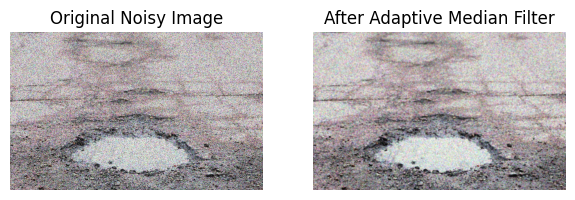

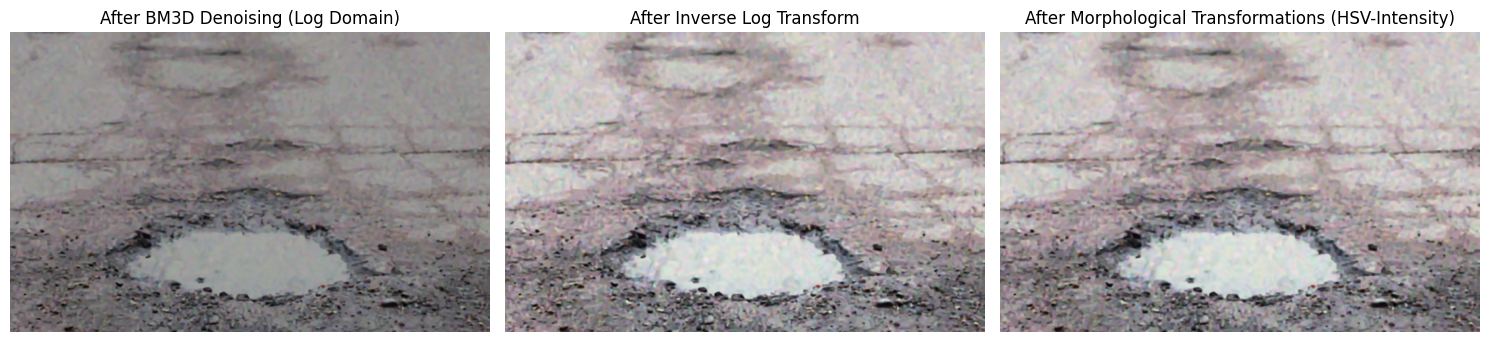

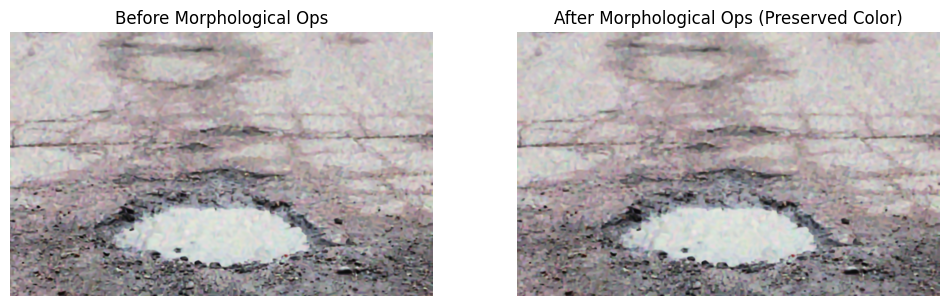

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from bm3d import bm3d

# --- PATH SETUP ---
NOISY_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Noisy_Pothole_Combined3'

# Get all image filenames
noisy_images_list = [f for f in os.listdir(NOISY_DATASET_PATH) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Check dataset existence
if not noisy_images_list:
    raise FileNotFoundError(f"No images found in: {NOISY_DATASET_PATH}")

# Pick one random image from the dataset
selected_image_name = '/content/drive/MyDrive/Colab Notebooks/Noisy_Pothole_Combined3/44_combined_noise.jpg'
image_path = os.path.join(NOISY_DATASET_PATH, selected_image_name)

print(f"Selected Image: {selected_image_name}")

# --- Step 1: Load the noisy image ---
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Original Noisy Image")
plt.axis('off')

# --- Step 2: Adaptive Median Filter (approximated by median filter) ---
median_filtered = cv2.medianBlur(img, 5)

plt.subplot(1, 4, 2)
plt.imshow(median_filtered)
plt.title("After Adaptive Median Filter")
plt.axis('off')

# --- Step 3: Log Transform ---
img_log = np.log1p(np.array(median_filtered, dtype="float32") / 255.0)

# --- Step 4: BM3D Denoising ---
bm3d_denoised = bm3d(img_log, sigma_psd=0.1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.clip(bm3d_denoised, 0, 1))
plt.title("After BM3D Denoising (Log Domain)")
plt.axis('off')

# --- Step 5: Inverse Log Transform ---
img_restored = np.expm1(bm3d_denoised) * 255.0
img_restored = np.uint8(np.clip(img_restored, 0, 255))

plt.subplot(1, 3, 2)
plt.imshow(img_restored)
plt.title("After Inverse Log Transform")
plt.axis('off')

# --- Step 6: Morphological Transformations in HSV (on Intensity only) ---
hsv = cv2.cvtColor(img_restored, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv)

kernel = np.ones((3, 3), np.uint8)

# Apply Opening followed by Closing on V channel (intensity)
v_morph = cv2.morphologyEx(v, cv2.MORPH_OPEN, kernel)
v_morph = cv2.morphologyEx(v_morph, cv2.MORPH_CLOSE, kernel)

# Merge channels back
hsv_morph = cv2.merge([h, s, v_morph])

# Convert back to RGB for final visualization
morph_colored = cv2.cvtColor(hsv_morph, cv2.COLOR_HSV2RGB)

plt.subplot(1, 3, 3)
plt.imshow(morph_colored)
plt.title("After Morphological Transformations (HSV-Intensity)")
plt.axis('off')

plt.tight_layout()
plt.show()

# --- Step 7: Show comparison ---
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_restored)
ax[0].set_title("Before Morphological Ops")
ax[0].axis('off')
ax[1].imshow(morph_colored)
ax[1].set_title("After Morphological Ops (Preserved Color)")
ax[1].axis('off')
plt.show()

IMAGE ENHANCEMENT

Gamma selected: 1.050 (mean V=161.95)


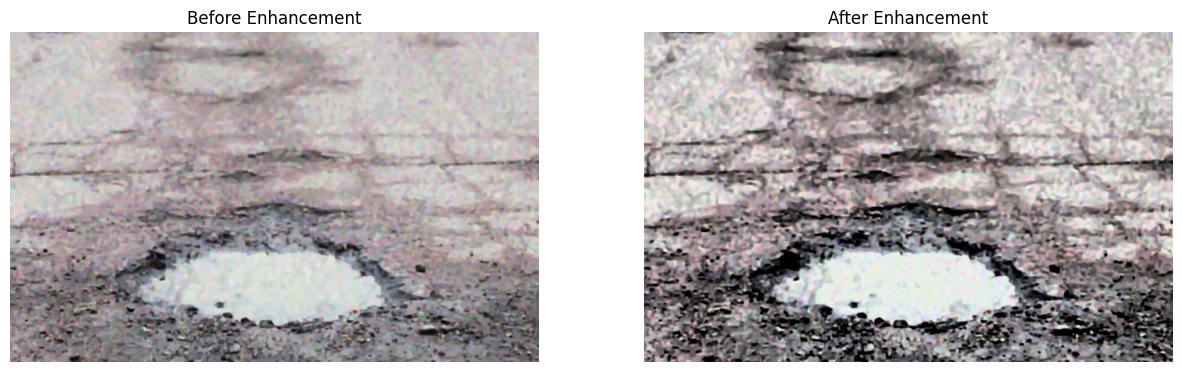

Brightness-regularized enhancement complete.


In [14]:
# ----Enhancement Pipeline----
import cv2
import numpy as np
import matplotlib.pyplot as plt

try:
    final_restored_image = morph_colored.copy()
except NameError:
    raise ValueError("final_restored_image missing from previous cell.")

img = final_restored_image.copy()

# Convert to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv)

# ---- Mild Contrast Stretching ----
p_low, p_high = np.percentile(v, (2, 98))
v_cs = np.clip((v - p_low) * 255.0 / (p_high - p_low + 1e-5), 0, 255).astype(np.uint8)

# ---- CLAHE ----
clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
v_clahe = clahe.apply(v_cs)

# ---- Adaptive Gamma ----
mean_val = np.mean(v_clahe)

if mean_val < 90:        # very dark
    gamma = 0.9
elif mean_val < 130:     # appropriately dark
    gamma = 1.0
elif mean_val < 180:     # slightly bright
    gamma = 1.05
else:                    # very bright → darken slightly
    gamma = 1.1

print(f"Gamma selected: {gamma:.3f} (mean V={mean_val:.2f})")

v_gamma = ((v_clahe / 255.0) ** gamma) * 255
v_gamma = np.uint8(np.clip(v_gamma, 0, 255))

# ---- Tone Map ----
v_tm = np.minimum(v_gamma, 240).astype(np.uint8)  # cap highlights

# Merge
hsv_out = cv2.merge([h, s, v_tm])
img_tuned = cv2.cvtColor(hsv_out, cv2.COLOR_HSV2RGB)

# ---- Unsharp Mask----
blurred = cv2.GaussianBlur(img_tuned, (3,3), 1.0)
sharp = cv2.addWeighted(img_tuned, 1.2, blurred, -0.2, 0)

# Clip final
final_enhanced_image = np.clip(sharp, 0, 255).astype(np.uint8)

# ---- Display ----
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Before Enhancement")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(final_enhanced_image)
plt.title("After Enhancement")
plt.axis('off')
plt.show()

print("Brightness-regularized enhancement complete.")


HELPER FUNCTION

In [15]:
# Helper function to display images in grid in Colab
import matplotlib.pyplot as plt
import cv2

def display_images_grid(images, titles, rows, cols, figsize=(15,8)):
    plt.figure(figsize=figsize)

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i+1)
        if len(img.shape) == 3:  # BGR to RGB if color
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

IMAGE SEGMENTATION

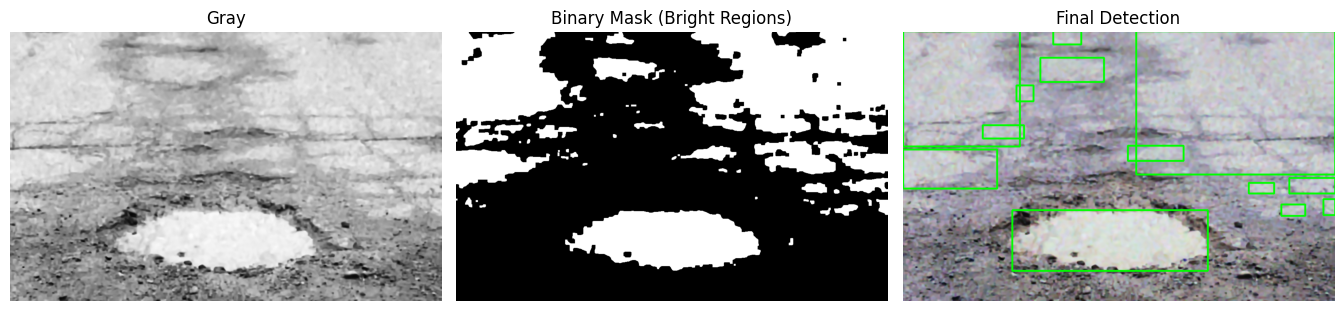

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_images_grid(images, titles, rows, cols, figsize=(15,8)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i+1)
        if len(img.shape)==3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
        plt.title(title); plt.axis('off')
    plt.tight_layout(); plt.show()

img = final_restored_image.copy()

# Gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#gray_blur = cv2.GaussianBlur(gray, (7,7), 0)

# K-means with k=2 (bright vs dark)
pixels = np.float32(gray_blur.reshape(-1,1))
k = 2
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,50,0.2)
_, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
centers = np.uint8(centers)

# brightest cluster = pothole here
pothole_val = np.max(centers)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((9,9)))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5)))

# Contours and bounding box
contours,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output = img.copy()
min_area = 800  # adjust if needed

for c in contours:
    if cv2.contourArea(c) > min_area:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(output, (x,y), (x+w,y+h), (0,255,0), 3)

display_images_grid(
    [gray, mask, output],
    ["Gray", "Binary Mask (Bright Regions)", "Final Detection"],
    rows=1, cols=4, figsize=(18,4)
)


In [ ]:
!pip install scikit-image

**Task 5: AI/ML Based Classification**

Objective: To classify the entire restored image as either containing a "Pothole" or being "Normal". This task uses a completely different approach (a deep learning model) to make a high-level judgment about the image content.

Training the Pothole Classification Model


Loading Normal Images: 100%|██████████| 352/352 [00:16<00:00, 21.35it/s]



Dataset Statistics:
Total images: 681
Pothole images: 329
Normal images: 352
Class balance: 48.31% potholes

Class weights: {0: np.float64(0.9665271966527197), 1: np.float64(1.0358744394618835)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,712,225 (33.23 MB)

 Trainable params: 8,710,561 (33.23 MB)

 Non-trainable params: 1,664 (6.50 KB)


Training the model with improved strategies
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.5992 - loss: 0.8957 - precision: 0.5706 - recall: 0.6313 - val_accuracy: 0.5732 - val_loss: 0.6919 - val_precision: 0.5490 - val_recall: 0.7000 - learning_rate: 1.0000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.8320 - loss: 0.3942 - precision: 0.8214 - recall: 0.8392 - val_accuracy: 0.5244 - val_loss: 0.6882 - val_precision: 0.6667 - val_recall: 0.0500 - learning_rate: 1.0000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.8748 - loss: 0.2759 - precision: 0.8349 - recall: 0.9098 - val_accuracy: 0.4878 - val_loss: 0.6984 - val_precision: 0.4878 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.8899 - loss: 0.3131 - precision: 0.8783 - recall: 0.9138 - val_accuracy: 0.5366 - val_loss: 0.6881 - val_precision: 0.5128 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/5

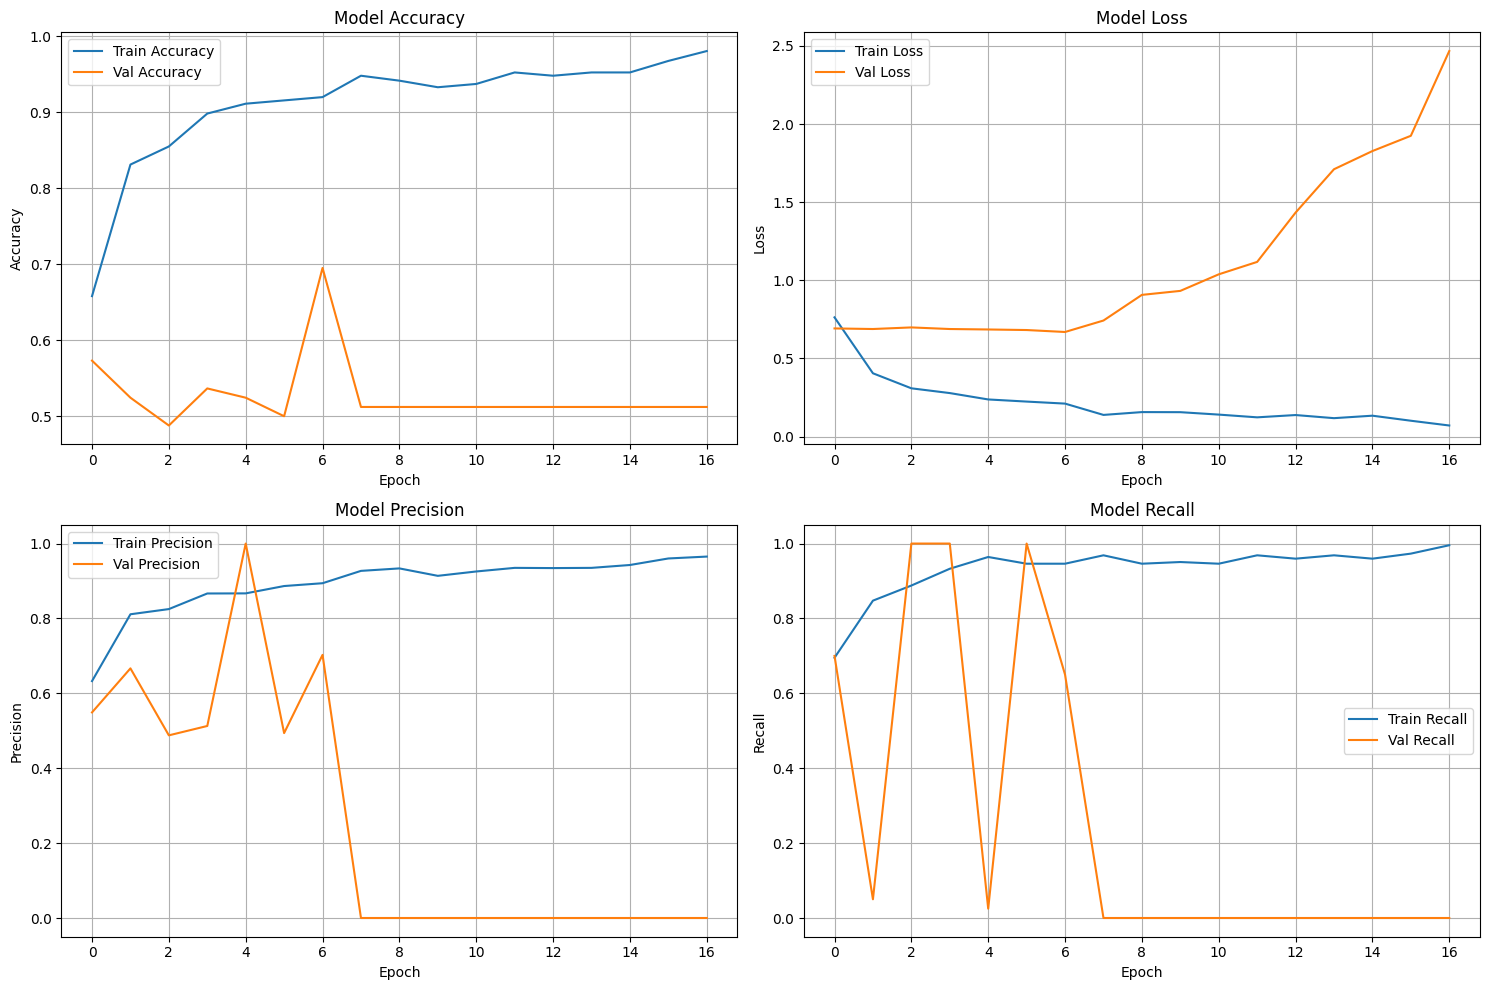


Model training complete!


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

print("Training the Pothole Classification Model")

# --- 1. DATA PREPARATION ---
CLEAN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Pothole_Dataset'
IMG_SIZE = (128, 128)
images = []
labels = []

pothole_dir = os.path.join(CLEAN_DATASET_PATH, 'Potholes')
normal_dir = os.path.join(CLEAN_DATASET_PATH, 'Normal')

# Load Pothole images (Label = 1)
for img_file in tqdm(os.listdir(pothole_dir), desc="Loading Pothole Images"):
    img_path = os.path.join(pothole_dir, img_file)
    img = cv2.imread(img_path)
    if img is not None:
        images.append(cv2.resize(img, IMG_SIZE))
        labels.append(1)

# Load Normal images (Label = 0)
for img_file in tqdm(os.listdir(normal_dir), desc="Loading Normal Images"):
    img_path = os.path.join(normal_dir, img_file)
    img = cv2.imread(img_path)
    if img is not None:
        images.append(cv2.resize(img, IMG_SIZE))
        labels.append(0)

X = np.array(images) / 255.0
y = np.array(labels)

print(f"\nDataset Statistics:")
print(f"Total images: {len(y)}")
print(f"Pothole images: {np.sum(y == 1)}")
print(f"Normal images: {np.sum(y == 0)}")
print(f"Class balance: {np.sum(y == 1) / len(y) * 100:.2f}% potholes")

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split training into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

# Compute class weights to handle imbalance
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}
print(f"\nClass weights: {class_weights}")

# --- 2. BUILD IMPROVED CNN MODEL ---
# More regularization and better architecture
pothole_classifier_model = Sequential([
    # First Conv Block
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Conv Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Conv Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Using a lower learning rate for better convergence
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
pothole_classifier_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

pothole_classifier_model.summary()

# --- 3. TRAIN WITH CALLBACKS ---
print("\nTraining the model with improved strategies")

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
history = pothole_classifier_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 4. EVALUATE ON TEST SET
print("\nEvaluating on test set...")
test_loss, test_acc, test_precision, test_recall = pothole_classifier_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test Recall: {test_recall*100:.2f}%")

# Calculate predictions for confusion matrix analysis
y_pred_probs = pothole_classifier_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(f"True Negatives (Normal correctly classified): {cm[0, 0]}")
print(f"False Positives (Normal misclassified as Pothole): {cm[0, 1]}")
print(f"False Negatives (Pothole misclassified as Normal): {cm[1, 0]}")
print(f"True Positives (Pothole correctly classified): {cm[1, 1]}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Pothole']))

# --- 5. PLOT TRAINING HISTORY ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss')
axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print("\nModel training complete!")

In [17]:
print("\n--- Classifying the Enhanced Image ---")

# Note: Run your enhancement pipeline cell before this section
# The enhancement cell should create 'final_enhanced_image'

# Use adjusted threshold based on validation performance
CLASSIFICATION_THRESHOLD = 0.5  # You can adjust this (try 0.4-0.6)

# Check if enhanced image exists, otherwise use restored image
try:
    image_to_classify = final_enhanced_image.copy()
    print("✓ Using enhanced image for classification")
except NameError:
    print("⚠ Enhanced image not found, trying to use restored image...")
    try:
        image_to_classify = morph_colored.copy()
        print("✓ Using morph_colored image")
    except NameError:
        try:
            image_to_classify = final_restored_image.copy()
            print("✓ Using final_restored_image")
        except NameError:
            raise ValueError("No image found for classification. Please run restoration/enhancement first.")

# Preprocess for model input
resized_image = cv2.resize(image_to_classify, IMG_SIZE)
normalized_image = resized_image / 255.0
input_batch = np.expand_dims(normalized_image, axis=0)

# Make prediction
prediction = pothole_classifier_model.predict(input_batch, verbose=0)
prediction_probability = prediction[0][0]

# Classify with threshold
if prediction_probability > CLASSIFICATION_THRESHOLD:
    class_label = f"Pothole ({prediction_probability*100:.2f}%)"
    text_color = (255, 0, 0)  # Red for pothole (BGR format)
    bg_color = (200, 200, 255)  # Light red background
    status = "DETECTED"
else:
    class_label = f"Normal ({(1-prediction_probability)*100:.2f}%)"
    text_color = (0, 255, 0)  # Green for normal (BGR format)
    bg_color = (200, 255, 200)  # Light green background
    status = "CLEAR"

print(f"Prediction Result: {class_label}")
print(f"Raw probability (Pothole): {prediction_probability:.4f}")
print(f"Confidence: {max(prediction_probability, 1-prediction_probability)*100:.2f}%")
print(f"Status: {status}")

# Create visualization with classification result
# Convert RGB to BGR for OpenCV operations
final_result_image = cv2.cvtColor(final_enhanced_image.copy(), cv2.COLOR_RGB2BGR)

# Add semi-transparent overlay bar at top
overlay = final_result_image.copy()
cv2.rectangle(overlay, (0, 0), (final_result_image.shape[1], 70), bg_color, -1)
cv2.addWeighted(overlay, 0.7, final_result_image, 0.3, 0, final_result_image)

# Add classification text
text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
cv2.putText(final_result_image, class_label, (10, 35),
            cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 2, cv2.LINE_AA)

# Add status indicator
status_text = f"Status: {status}"
cv2.putText(final_result_image, status_text, (10, 60),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2, cv2.LINE_AA)

# Convert back to RGB for matplotlib
final_result_image_rgb = cv2.cvtColor(final_result_image, cv2.COLOR_BGR2RGB)

# Display final result
plt.figure(figsize=(12, 10))
plt.imshow(final_result_image_rgb)
plt.title("Final Analysis: Enhanced Image with Classification", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Optional: Show some test examples to verify model behavior
print("\n--- Displaying sample predictions from test set ---")
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i in range(10):
    idx = random.randint(0, len(X_test)-1)
    img = X_test[idx]
    true_label = y_test[idx]

    pred_prob = pothole_classifier_model.predict(np.expand_dims(img, axis=0))[0][0]
    pred_label = 1 if pred_prob > CLASSIFICATION_THRESHOLD else 0

    axes[i].imshow(img)
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(
        f"True: {'Pothole' if true_label == 1 else 'Normal'}\n"
        f"Pred: {'Pothole' if pred_label == 1 else 'Normal'} ({pred_prob:.2f})",
        color=color
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.